In [1]:
# Making Extinction Proxy 
# Figure 8 (as of now) 

In [2]:
# Loading RC data 

import pickle, os 
from pathlib import Path

data_dir = Path(os.getcwd()).parent / "assets" 

with open(data_dir / "NRCB1.pickle", "rb") as f: 
    NRCB1 = pickle.load(f)
with open(data_dir / "NRCB2.pickle", "rb") as f: 
    NRCB2 = pickle.load(f) 
with open(data_dir / "NRCB3.pickle", "rb") as f: 
    NRCB3 = pickle.load(f) 
with open(data_dir / "NRCB4.pickle", "rb") as f: 
    NRCB4 = pickle.load(f)

Text(0.5, 0, '$m_{F212N}$')

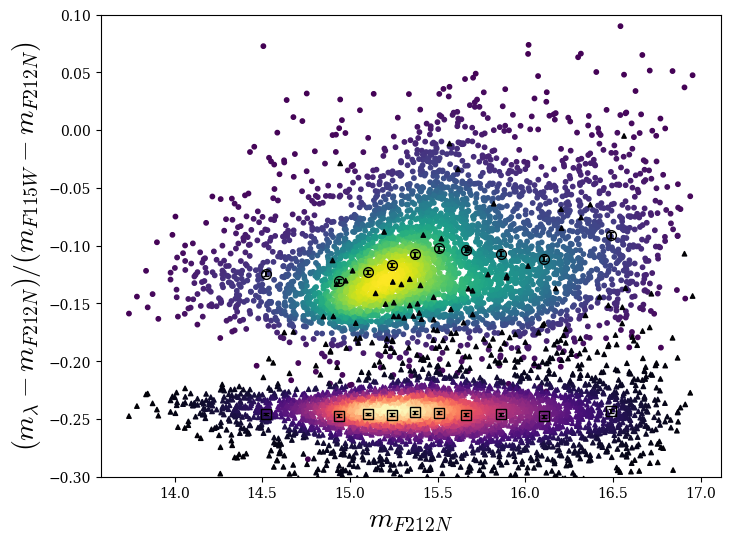

In [3]:
# Plotting NRCB1 Only 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import linregress, gaussian_kde 

plt.rcParams.update({
    "font.family"      : "serif",
    "mathtext.fontset" : "cm",             
    "mathtext.rm"      : "serif",         
})

figure, axis = plt.subplots(1, 1, figsize=(8, 6)) 

mF115W = NRCB1["mF115W"] 
mF212N = NRCB1["mF212N"] 
mF323N = NRCB1["mF323N"] 
mF405N = NRCB1["mF405N"] 

finite_mask = (
    np.isfinite(mF115W) & 
    np.isfinite(mF212N) & 
    np.isfinite(mF323N) & 
    np.isfinite(mF405N) 
) 
mF115W = mF115W[finite_mask] 
mF212N = mF212N[finite_mask] 
mF323N = mF323N[finite_mask] 
mF405N = mF405N[finite_mask] 

# x, y coordinates 
x = mF212N 
y_F323N = (mF323N - mF212N) / (mF115W - mF212N) 
y_F405N = (mF405N - mF212N) / (mF115W - mF212N) 

# coloring by density 
xyF323N = np.vstack([x, y_F323N])
kde_F323N = gaussian_kde(xyF323N)(xyF323N) 
xyF405N = np.vstack([x, y_F405N])
kde_F405N = gaussian_kde(xyF405N)(xyF405N) 

plt.scatter(x, y_F323N, c=kde_F323N, cmap="viridis", marker='o', s=10, label="F323N") 
plt.scatter(x, y_F405N, c=kde_F405N, cmap="magma", marker='^', s=10, label="F405N") 

Nbins = 10                                  
edges = np.quantile(x, np.linspace(0, 1, Nbins + 1))
idx   = np.digitize(x, edges[1:-1])        

def bin_stats(y):
    mu  = np.array([y[idx == k].mean() for k in range(Nbins)])
    se = np.array([y[idx == k].std(ddof=1)  / np.sqrt((idx == k).sum())
                   for k in range(Nbins)])
    xc = np.array([x[idx == k].mean() for k in range(Nbins)])
    return xc, mu, se

xc323, mu323, se323 = bin_stats(y_F323N)
xc405, mu405, se405 = bin_stats(y_F405N)

axis.errorbar(xc323, mu323, yerr=se323, fmt='o',
              mfc='none', c='k', ms=7, capsize=2, label='F323N Mean')
axis.errorbar(xc405, mu405, yerr=se405, fmt='s',
              mfc='none', c='k', ms=7, capsize=2, label='F405N Mean')

plt.ylim(-0.3, 0.1)
axis.set_ylabel(r"$(m_\lambda - m_{F212N}) / (m_{F115W} - m_{F212N})$", fontsize=20) 
axis.set_xlabel(r"$m_{F212N}$", fontsize=20) 

In [4]:
# Is the upward drift from F323N real or within photometric erros? 
import tqdm

# photometric errors 
meF323N = NRCB1["meF323N"][finite_mask] 
meF212N = NRCB1["meF212N"][finite_mask] 
meF115W = NRCB1["meF115W"][finite_mask]

# monte carlo jitter 
Ndraw  = 10000 
slopes = np.empty(Ndraw) 

for j in tqdm.tqdm(range(Ndraw)): 
    m115 = mF115W + np.random.normal(0, meF115W) 
    m212 = mF212N + np.random.normal(0, meF212N) 
    m323 = mF323N + np.random.normal(0, meF323N) 

    y    = (m323 - m212) / (m115 - m212) 
    slope, _, _, _, _ = linregress(m212, y)
    slopes[j] = slope 

slope_obs, _, _, _, _ = linregress(mF212N, y_F323N) 
p_two_tailed = (np.abs(slopes) >= np.abs(slope_obs)).mean() 

print(f"The observed slope: {slope_obs:.4f}") 
print(f"Two Tailed p: {p_two_tailed:4f}")

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1438.58it/s]

The observed slope: 0.0172
Two Tailed p: 0.388000


In [5]:
# Since p is fairly large, we consider it to be within uncertainty 